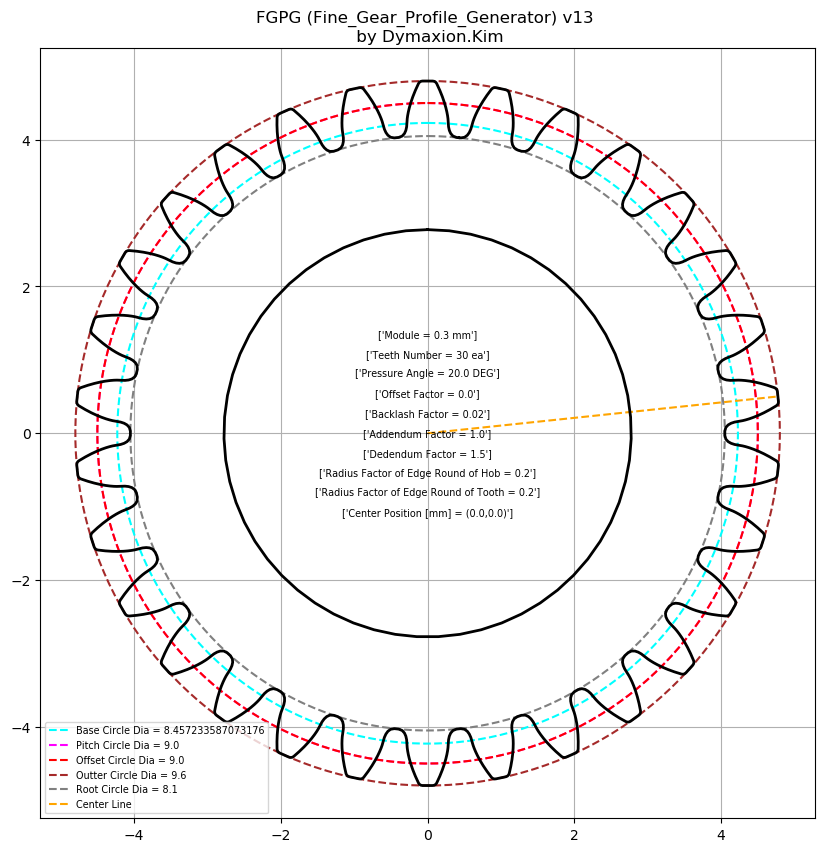

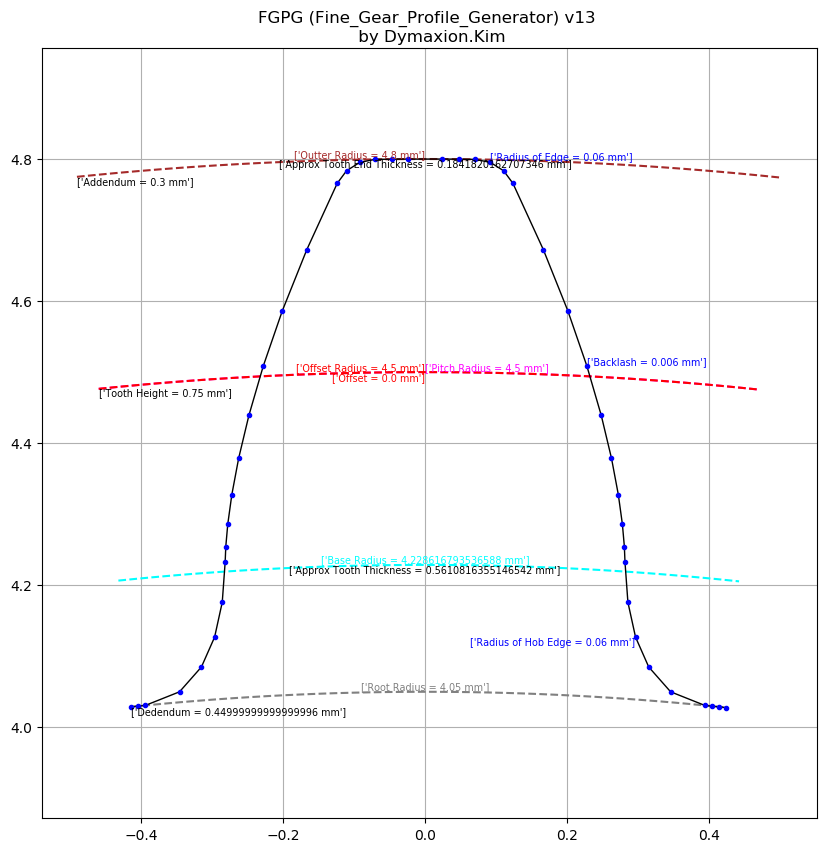

Process(`chmod 751 case.sh`, ProcessExited(0))

In [27]:
#########################################################################
# FGPG (Fine_Gear_Profile_Generator) V13
# 20181127
# by Dongho Kim  from Korea
# dymaxion.kim@gmail.com
# http://dymaxionkim.blogspot.kr/
#########################################################################
## Ref.
# http://tro.kr/29
# http://en.wikipedia.org/wiki/Coordinate_rotations_and_reflections
# http://dip28p.web.fc2.com/
#########################################################################
## History
# 20141114 V0.44 : SageMath Version
# 20150519 V0.1 : Trying to Conversion for Julia, Trying Interact Macro
# 20150519 V0.2 : Studying about Lack
# 20150527 V01 : Plotting Whole Gear at first
# 20150527 V02 : Trying Interact Macro
# 20150527 V03 : Debug V01
# 20150527 V04 : Adding Annotations, Saving Profile Data File, ...
# 20150527 V05 : Adding More Error Checks, Making geo File
# 20150528 V06 : Debug Making geo File
# 20150528 V07 : Align vertically Gear, Add Shaft
# 20150528 V08 : Modifying Sequences, Debug Making geo File, Make new Figure, Make svg Pictures, Save scr File, Modify Annotations
# 20150530 V09 : Modifying Shaft, Internal-External Condition, geo File
# 20150531 V10 : Adding version Variable
# 20150602 V11 : Making case.sif, case.bat, case.sh files
# 20161022 V12 : Conversion for Julia V0.5
# 20181127 V13 : Conversion for Julia V1.0
#########################################################################
## Todo
# Write Theory Doc
# Write User Manual
# Write Some Actual Examples
# Tip Relief to Modifying Tooth Profile
# Profile Repairing in Undercut Condition
# Change Result File Name based in Time
# Build to Standalone Executable

using CSV
using DataFrames
using PyPlot
PyPlot.svg(true)

############################
# Parameters
version = "v13"
m = 1  # Module
z = 20  # Teeth Number
alpha_0_deg = 20  # Pressure Angle [Deg]
x = 0.2  # Offset Factor
b = 0  # Backlash Factor
a = 1.0  # Addendum of Tooth
d = 1.2  # Dedendum of Tooth
c = 0.3  # Radius Factor of Edge Round of Hob
e = 0.2  # Radius Factor of Edge Round of Tooth
# Center of Gear
x_0 = 0
y_0 = 0
# Segmentation Points Numbers for each curves
seg_circle = 360
seg_involute = 50
seg_edge_r = 4
seg_root_r = 20
seg_center = 2
seg_outter = 4
seg_root = 4


############################
# Input Parameters from input4fgpg.csv file
input4fgpg = CSV.read("input4fgpg.csv")
m = Float64(input4fgpg[1,3])
z = Int(input4fgpg[2,3])
alpha_0_deg = Float64(input4fgpg[3,3])
alpha_0 = alpha_0_deg*2*pi/360
x = Float64(input4fgpg[4,3])
b = Float64(input4fgpg[5,3])
a = Float64(input4fgpg[6,3])
d = Float64(input4fgpg[7,3])
c = Float64(input4fgpg[8,3])
e = Float64(input4fgpg[9,3])
x_0 = Float64(input4fgpg[10,3])
y_0 = Float64(input4fgpg[11,3])
seg_circle = Int(input4fgpg[12,3])
seg_involute = Int(input4fgpg[13,3])
seg_edge_r = Int(input4fgpg[14,3])
seg_root_r = Int(input4fgpg[15,3])
seg_center = Int(input4fgpg[16,3])
seg_outter = Int(input4fgpg[17,3])
seg_root = Int(input4fgpg[18,3])


############################
# Involute Curve
# alpha_m = Center Line's Slope [Rad]
alpha_m = pi/z
# alpha_is = Start Angle for Involute Curve
alpha_is = alpha_0 + pi/(2*z) + b/(z*cos.(alpha_0)) - (1+2*x/z)*sin.(alpha_0)/cos.(alpha_0)
# theta_is = Minimum Range of Parameter to Draw Involute Curve
theta_is = sin.(alpha_0)/cos.(alpha_0) + 2*(c*(1-sin.(alpha_0))+x-d)/(z*cos.(alpha_0)*sin.(alpha_0))
# theta_ie = Maximum Range of Parameter to Draw Involute Curve
theta_ie = 2*e/(z*cos.(alpha_0)) + sqrt.( ((z+2*(x+a-e))/(z*cos.(alpha_0)))^2 - 1 )
# Condition of theta_ie
if alpha_m<alpha_is+theta_ie-atan.(theta_ie)
    # theta_ie를 뉴튼라프슨법으로 수치해석하여 근사해를 다시 구해서 작도에 적용해야 함 (아직 미구현)
end
# Condition of Undercut
if theta_is<0 && (z/2)*sin.(alpha_0)^2<d-x-c*(1-sin.(alpha_0))
    # 언더컷 발생한 경우이므로, theta_ie, theta_te를 비선형 연립방정식 반복해법으로 다시 구해야 함 (아직 미구현)
end
THETA1 = range(theta_is,stop=theta_ie,length=seg_involute) 
X1 = ones(length(THETA1))
Y1 = X1
X1 = x_0 .+ (1 ./2).*m.*z.*cos.(alpha_0).*sqrt.(1 .+THETA1.^2).*cos.(alpha_is .+THETA1 .-atan.(THETA1))
Y1 = y_0 .+ (1 ./2).*m.*z.*cos.(alpha_0).*sqrt.(1 .+THETA1.^2).*sin.(alpha_is .+THETA1 .-atan.(THETA1))
#plot(X1,Y1,color="red",linestyle="-")


############################
# Edge Round Curve of Tooth
# alpha_e = Angle between Tooth's Center & End Point of Tooth
alpha_e = alpha_is + theta_ie - atan.(sqrt.( ( (z .+2*(x+a-e))/(z*cos.(alpha_0)) )^2 - 1 ))
# modify "e"
if alpha_e>alpha_m && alpha_m>alpha_is+theta_ie-atan.(theta_ie)
    e = (z/2)*cos.(alpha_0)*( theta_ie - sqrt.( (1/cos.(alpha_is+theta_ie-alpha_m))^2-1 ) )
end
# x_e, y_e = Location of Tooth's End Point
x_e = x_0 + m*((z/2)+x+a)*cos.(alpha_e)
y_e = y_0 + m*((z/2)+x+a)*sin.(alpha_e)
# x_e0, y_e0 = Location of Edge Round Center
x_e0 = m*(z/2+x+a-e)*cos.(alpha_e) + x_0
y_e0 = m*(z/2+x+a-e)*sin.(alpha_e) + y_0
# Parameter Range of Edge Round
theta3_min = atan.((Y1[length(Y1)]-y_e0)/(X1[length(X1)]-x_e0))
theta3_max = atan.((y_e-y_e0)/(x_e-x_e0))
THETA3 = range(theta3_min,stop=theta3_max,length=seg_edge_r) 
X3 = m*e*cos.(THETA3) .+ x_e0
Y3 = m*e*sin.(THETA3) .+ y_e0
#plot(X3,Y3,color="green",linestyle="-")


############################
# Root Round Curve of Tooth
# Condition Check
# alpha_ts = Start Angle of Root Round Curve
# THETA_s = Substitution Variable to plot Root Round Curve
alpha_ts = (2*(c*(1-sin.(alpha_0))-d)*sin.(alpha_0)+b)/(z*cos.(alpha_0)) - 2*c*cos.(alpha_0)/z + pi/(2*z)
theta_te = 2*c*cos.(alpha_0)/z - 2*(d-x-c*(1-sin.(alpha_0)))*cos.(alpha_0)/(z*sin.(alpha_0))
THETA_t  = range(0,stop=theta_te,length=seg_root_r) 
if c!=0 && (d-x-c)==0
    # mc를 반지름으로 하는 원호를 그려서 대체하게 됨
    THETA_s = (pi/2)*ones(length(THETA_t))
    elseif c==0 && (d-x-c)==0
    # 루트커브 작도 생략하고, (x_is,y_is) 점을 대칭으로 이뿌리호를 그려서 대체하게 됨
    elseif (d-x-c)!=0
    THETA_s = atan.((m*z*THETA_t/2)/(m*d-m*x-m*c))
end
X_t = x_0 .+ m*( (z/2+x-d+c).*cos.(THETA_t.+alpha_ts) .+ (z/2)*THETA_t.*sin.(THETA_t.+alpha_ts) - c.*cos.(THETA_s.+THETA_t.+alpha_ts) )
Y_t = y_0 .+ m*( (z/2+x-d+c).*sin.(THETA_t.+alpha_ts) .- (z/2)*THETA_t.*cos.(THETA_t.+alpha_ts) - c.*sin.(THETA_s.+THETA_t.+alpha_ts) )
#plot(X_t,Y_t,color="green",linestyle="-")


############################
# Outter Arc
#alpha_em = 2*alpha_m-alpha_e
#x_em = x_0 + m*(z/2+x+a)*cos.(alpha_em)
#y_em = y_0 + m*(z/2+x+a)*cos.(alpha_em)
THETA6  = range(alpha_e,stop=alpha_m,length=seg_outter) 
X6 = m*(z/2+a+x)*cos.(THETA6) .+x_0
Y6 = m*(z/2+a+x)*sin.(THETA6) .+y_0
#plot(X6,Y6,color="red",linestyle="-")


############################
# Root Arc
#x_rm = x_0 + m*(z/2+x-d)*cos.(alpha_ts)
#y_rm = y_0 - m*(z/2+x-d)*sin.(alpha_ts)
THETA7  = range(0,stop=alpha_ts,length=seg_root) 
X7 = m*(z/2-d+x)*cos.(THETA7) .+x_0
Y7 = m*(z/2-d+x)*sin.(THETA7) .+y_0
#plot(X7,Y7,color="red",linestyle="-")


############################
# Combine Curves
# Not using Root Round Curve (X_t,Y_t)
if c==0 && (d-x-c)==0
    Xc = X7[1:length(X7)-1]
    Yc = Y7[1:length(Y7)-1]
else
    Xc = [ X7[1:length(X7)-1]; X_t[1:length(X_t)-1] ]
    Yc = [ Y7[1:length(Y7)-1]; Y_t[1:length(Y_t)-1] ]
end
# Not using Edge Round Curve (X3,Y3)
if e==0 || alpha_m==alpha_is+theta_ie-atan.(theta_ie)
    Xc = [ Xc; X1[1:length(X1)-1] ]
    Yc = [ Yc; Y1[1:length(Y1)-1] ]
else
    Xc = [ Xc; X1[1:length(X1)-1]; X3[1:length(X3)-1] ]
    Yc = [ Yc; Y1[1:length(Y1)-1]; Y3[1:length(Y3)-1] ]
end
# Not using Outter Arc (X6,Y6)
if alpha_e == alpha_m || alpha_m==alpha_is+theta_ie-atan.(theta_ie)
    Xc = Xc
    Yc = Yc
else
    Xc = [ Xc; X6[1:length(X6)-1] ]
    Yc = [ Yc; Y6[1:length(Y6)-1] ]
end
#Xc = [ X7[1:length(X7)-1]; X_t[1:length(X_t)-1]; X1[1:length(X1)-1]; X3[1:length(X3)-1]; X6[1:length(X6)-1]]
#Yc = [ Y7[1:length(Y7)-1]; Y_t[1:length(Y_t)-1]; Y1[1:length(Y1)-1]; Y3[1:length(Y3)-1]; Y6[1:length(Y6)-1]]
#plot(Xc,Yc,color="black",linestyle="-",linewidth=2)


############################
# Make Whole One Tooth
Xc2 = Xc[2:length(Xc)]
Yc2 = Yc[2:length(Yc)]
# Reflect Transform
Xcc = cos.(2*alpha_m)*(Xc2 .-x_0) .+ sin.(2*alpha_m)*(Yc2 .-y_0)
Ycc = sin.(2*alpha_m)*(Xc2 .-x_0) .- cos.(2*alpha_m)*(Yc2 .-y_0)
# Location Transform to (x_0,y_0)
Xcc = Xcc .+ x_0
Ycc = Ycc .+ y_0
# Invert
Xcc = Xcc[length(Xcc):-1:1]
Ycc = Ycc[length(Ycc):-1:1]
# Combine
Xcc = [Xc; Xcc]
Ycc = [Yc; Ycc]
#plot(Xcc,Ycc,color="black",linestyle="-",linewidth=2)


############################
# Align to Top
align_angle = pi/2-pi/z
X_align = Xcc
Y_align = Ycc
# Rotate
X_align = cos.(align_angle)*(Xcc .-x_0) .- sin.(align_angle)*(Ycc .-y_0)
Y_align = sin.(align_angle)*(Xcc .-x_0) .+ cos.(align_angle)*(Ycc .-y_0)
# Location Transform to (x_0,y_0)
X_align = X_align .+ x_0
Y_align = Y_align .+ y_0
#plot(X_align,Y_align,color="black",linestyle="-",linewidth=2)


############################
# Make Whole Gear
p_angle = 2*pi/z
Xccc = X_align
Yccc = Y_align
Xtemp = X_align[2:length(X_align)]
Ytemp = Y_align[2:length(Y_align)]
for i = 1:z-1
    # Rotate
    Xtemp = cos.(p_angle*i).*(X_align[2:length(X_align)] .- x_0) .- sin.(p_angle*i).*(Y_align[2:length(Y_align)] .- y_0)
    Ytemp = sin.(p_angle*i).*(X_align[2:length(X_align)] .- x_0) .+ cos.(p_angle*i).*(Y_align[2:length(Y_align)] .- y_0)
    # Location Transform to (x_0,y_0)
    Xtemp = Xtemp .+ x_0
    Ytemp = Ytemp .+ y_0
    Xccc = [Xccc; Xtemp]
    Yccc = [Yccc; Ytemp]
end


############################
# Plot Figure
f=figure(figsize=(10,10))
grid("on")
title("FGPG (Fine_Gear_Profile_Generator) $version \n by Dymaxion.Kim")
axis("equal")


############################
# Base, Pitch, Offset, Outter, Root Circle
THETA0 = range(0.0,stop=2*pi,length=seg_circle) 
# Base Circle
base_dia = m*z*cos.(alpha_0)
X_base = base_dia/2*sin.(THETA0) .+ x_0
Y_base = base_dia/2*cos.(THETA0) .+ y_0
plot(X_base, Y_base, color="cyan", linestyle="--")
# Pitch Circle
pitch_dia = m*z
X_pitch = pitch_dia/2*sin.(THETA0) .+ x_0
Y_pitch = pitch_dia/2*cos.(THETA0) .+ y_0
plot(X_pitch, Y_pitch, color="magenta", linestyle="--")
# Offset Circle
offset_dia = 2*m*(z/2+x)
X_offset = (offset_dia/2)*sin.(THETA0) .+ x_0
Y_offset = (offset_dia/2)*cos.(THETA0) .+ y_0
plot(X_offset, Y_offset, color="red", linestyle="--")
# Outter Circle
outter_dia = 2*m*(z/2+x+a)
X_out = (outter_dia/2)*sin.(THETA0) .+ x_0
Y_out = (outter_dia/2)*cos.(THETA0) .+ y_0
plot(X_out, Y_out, color="brown", linestyle="--")
# Root Circle
root_dia = 2*m*(z/2+x-d)
X_root = (root_dia/2)*sin.(THETA0) .+ x_0
Y_root = (root_dia/2)*cos.(THETA0) .+ y_0
plot(X_root, Y_root, color="grey", linestyle="--")


############################
# Center Line of Tooth
X_m = range(x_0,stop=(m*(z/2+a+x))*cos.(alpha_m)+x_0,length=seg_center) 
Y_m = (X_m .- x_0).*tan.(alpha_m) .+ y_0
plot(X_m,Y_m,color="orange",linestyle="--")


############################
# Shaft
THETA8 = range(0,stop=2*pi,length=2*z) 
if a<d  # Outternal Gear
    d_shaft = m*(z+x-d)-m*(4*(a+d))
    elseif a>d  # Internal Gear
    d_shaft = m*(z+x+a)+m*(4*(a+d))
    elseif a==d  # No correct
    #d_shaft = m*(z+x-d)-m*(2*(a+d))
    d_shaft = 0
end
X_shaft = (d_shaft/2)*sin.(THETA8) .+ x_0
Y_shaft = (d_shaft/2)*cos.(THETA8) .+ y_0
plot(X_shaft, Y_shaft, color="black", linestyle="-", linewidth=2)


############################
# Plot Whole Gear
plot(Xccc,Yccc,color="black",linestyle="-",linewidth=2)
char_scale = 0.03*m*z
annotate(["Module = $m mm"],xy=(x_0,y_0+5*char_scale),ha="center",va="center",color="black",fontsize="x-small")
annotate(["Teeth Number = $z ea"],xy=(x_0,y_0+4*char_scale),ha="center",va="center",color="black",fontsize="x-small")
annotate(["Pressure Angle = $alpha_0_deg DEG"],xy=(x_0,y_0+3*char_scale),ha="center",va="center",color="black",fontsize="x-small")
annotate(["Offset Factor = $x"],xy=(x_0,y_0+2*char_scale),ha="center",va="center",color="black",fontsize="x-small")
annotate(["Backlash Factor = $b"],xy=(x_0,y_0+1*char_scale),ha="center",va="center",color="black",fontsize="x-small")
annotate(["Addendum Factor = $a"],xy=(x_0,y_0+0*char_scale),ha="center",va="center",color="black",fontsize="x-small")
annotate(["Dedendum Factor = $d"],xy=(x_0,y_0-1*char_scale),ha="center",va="center",color="black",fontsize="x-small")
annotate(["Radius Factor of Edge Round of Hob = $c"],xy=(x_0,y_0-2*char_scale),ha="center",va="center",color="black",fontsize="x-small")
annotate(["Radius Factor of Edge Round of Tooth = $e"],xy=(x_0,y_0-3*char_scale),ha="center",va="center",color="black",fontsize="x-small")
annotate(["Center Position [mm] = ($x_0,$y_0)"],xy=(x_0,y_0-4*char_scale),ha="center",va="center",color="black",fontsize="x-small")
legend(["Base Circle Dia = $base_dia", "Pitch Circle Dia = $pitch_dia", "Offset Circle Dia = $offset_dia",
    "Outter Circle Dia = $outter_dia", "Root Circle Dia = $root_dia", "Center Line"], loc="lower left", fontsize="x-small")
savefig("case01.svg")


############################
# Figuer 2
f2=figure(figsize=(10,10))
grid("on")
title("FGPG (Fine_Gear_Profile_Generator) $version \n by Dymaxion.Kim")
axis("equal")


############################
# Base, Pitch, Offset, Outter, Root Circle 2
THETA9 = range(atan.(X_align[length(X_align)]/Y_align[length(Y_align)]),stop=atan.(X_align[1]/Y_align[1]),length=Int(seg_circle/10)) 
# Base Circle
X_base9 = base_dia/2*sin.(THETA9) .+ x_0
Y_base9 = base_dia/2*cos.(THETA9) .+ y_0
plot(X_base9, Y_base9, color="cyan", linestyle="--")
# Pitch Circle
X_pitch9 = pitch_dia/2*sin.(THETA9) .+ x_0
Y_pitch9 = pitch_dia/2*cos.(THETA9) .+ y_0
plot(X_pitch9, Y_pitch9, color="magenta", linestyle="--")
# Offset Circle
X_offset9 = (offset_dia/2)*sin.(THETA9) .+ x_0
Y_offset9 = (offset_dia/2)*cos.(THETA9) .+ y_0
plot(X_offset9, Y_offset9, color="red", linestyle="--")
# Outter Circle
X_out9 = (outter_dia/2)*sin.(THETA9) .+ x_0
Y_out9 = (outter_dia/2)*cos.(THETA9) .+ y_0
plot(X_out9, Y_out9, color="brown", linestyle="--")
# Root Circle
X_root9 = (root_dia/2)*sin.(THETA9) .+ x_0
Y_root9 = (root_dia/2)*cos.(THETA9) .+ y_0
plot(X_root9, Y_root9, color="grey", linestyle="--")


############################
# Plot only One Tooth
plot(X_align,Y_align,color="black",linestyle="-",linewidth=1)
plot(X_align,Y_align,"b.")
base_radius = base_dia/2
pitch_radius = pitch_dia/2
offset_radius = offset_dia/2
outter_radius = outter_dia/2
root_radius = root_dia/2
xmm = x*m
emm = e*m
bmm = b*m
cmm = c*m
annotate(["Base Radius = $base_radius mm"],xy=(0,base_dia/2),ha="center",va="bottom",color="cyan",fontsize="x-small")
annotate(["Pitch Radius = $pitch_radius mm"],xy=(0,pitch_dia/2),ha="left",va="bottom",color="magenta",fontsize="x-small")
annotate(["Offset Radius = $offset_radius mm"],xy=(0,offset_dia/2),ha="right",va="bottom",color="red",fontsize="x-small")
annotate(["Outter Radius = $outter_radius mm"],xy=(0,outter_dia/2),ha="right",va="bottom",color="brown",fontsize="x-small")
annotate(["Root Radius = $root_radius mm"],xy=(0,root_dia/2),ha="center",va="bottom",color="grey",fontsize="x-small")
annotate(["Offset = $xmm mm"],xy=(0,offset_dia/2),ha="right",va="top",color="red",fontsize="x-small")
annotate(["Radius of Hob Edge = $cmm mm"],
        xy=(X_align[seg_root+Int(seg_root_r/2)],Y_align[seg_root+Int(seg_root_r/2)]),
        ha="right",va="top",color="blue",fontsize="x-small")
annotate(["Radius of Edge = $emm mm"],
        xy=(X_align[seg_root+seg_root_r+seg_involute],Y_align[seg_root+seg_root_r+seg_involute]),
        ha="left",va="bottom",color="blue",fontsize="x-small")
annotate(["Backlash = $bmm mm"],
        xy=(X_align[seg_root+seg_root_r+Int(seg_involute/2)],Y_align[seg_root+seg_root_r+Int(seg_involute/2)]),
        ha="left",va="bottom",color="blue",fontsize="x-small")
amm = a*m
dmm = d*m
hmm = amm+dmm
tmm = 2*X_align[seg_root+seg_root_r]
#temm = 2*X_align[seg_root+seg_root_r+seg_involute+Int(seg_edge_r/2)]
temm = 2*X_align[seg_root+seg_root_r+seg_involute]
annotate(["Addendum = $amm mm"],xy=(X_out9[1],Y_out9[1]),ha="left",va="top",color="black",fontsize="x-small")
annotate(["Dedendum = $dmm mm"],xy=(X_root9[1],Y_root9[1]),ha="left",va="top",color="black",fontsize="x-small")
annotate(["Tooth Height = $hmm mm"],xy=(X_offset9[1],Y_offset9[1]),ha="left",va="top",color="black",fontsize="x-small")
annotate(["Approx Tooth Thickness = $tmm mm"],xy=(0,base_dia/2),ha="center",va="top",color="black",fontsize="x-small")
annotate(["Approx Tooth End Thickness = $temm mm"],xy=(0,outter_dia/2),ha="center",va="top",color="black",fontsize="x-small")

savefig("case02.svg")


############################
# Save case.csv
df = DataFrame(X_points=Xccc, Y_Points=Yccc)
CSV.write("case.csv", df)


############################
# Save case.geo
fileout = open("case.geo", "w")
println(fileout, "cl__1 = 1;")
num_Point_gear = length(Xccc)
num_Line_gear = num_Point_gear-1
num_Point_shaft = num_Point_gear + length(X_shaft) -1
num_Line_shaft = num_Point_shaft-1
for i=1:num_Point_gear
    println(fileout, "Point(",i,") = {",Xccc[i],", ",Yccc[i],", ",0,", ","cl__1};")
end
for i=num_Point_gear+1:num_Point_shaft
    println(fileout, "Point(",i,") = {",X_shaft[i-num_Point_gear],", ",Y_shaft[i-num_Point_gear],", ",0,", ","cl__1};")
end
for j=1:num_Line_gear
    println(fileout, "Line(",j,") = {",j,", ",j+1,"};")
end
println(fileout, "Line(",num_Line_gear+1,") = {",num_Line_gear+1,", ",1,"};")
for j=num_Line_gear+2:num_Line_shaft
    println(fileout, "Line(",j,") = {",j,", ",j+1,"};")
end
println(fileout, "Line(",num_Line_shaft+1,") = {",num_Line_shaft+1,", ",num_Line_gear+2,"};")
# Combine
#array_LineLoop = [1:num_Line_shaft+1]
array_LineLoop = Array{Int}(range(1,stop=num_Line_shaft+1,length=num_Line_shaft+1))
array_LineLoop[num_Line_gear+2:num_Line_shaft+1] = -array_LineLoop[num_Line_gear+2:num_Line_shaft+1]
array_LineLoop = string(array_LineLoop)
array_LineLoop = array_LineLoop[2:length(array_LineLoop)-1]
println(fileout, "Line Loop(",num_Line_shaft+3,") = {",array_LineLoop,"};")
println(fileout, "Plane Surface(",num_Line_shaft+3,") = {",num_Line_shaft+3,"};")
#Physical Line(13) = {8, 9};
#Physical Surface(14) = {11};
array_PhysicalLine = [num_Line_gear+2:num_Line_shaft+1]
array_PhysicalLine = string(array_PhysicalLine)
array_PhysicalLine = array_PhysicalLine[2:length(array_PhysicalLine)-1]
#println(fileout, "Physical Line(",num_Line_shaft+4,") = {",array_PhysicalLine,"};")
# Position for Normal Force
#position_NormalForce = (length(Xcc)-1) - (seg_root+seg_root_r-2) - (seg_involute-3)
#println(fileout, "Physical Line(",num_Line_shaft+5,") = {",position_NormalForce,"};")
# Fixed
#println(fileout, "Physical Surface(",num_Line_shaft+6,") = {",num_Line_shaft+3,"};")
println(fileout, "Mesh.ElementOrder = 2;")
println(fileout, "Mesh.RecombineAll = 1;")
close(fileout)


############################
# Save case.scr
fileout = open("case.scr", "w")
println(fileout, "spline")
for i=1:num_Point_gear
    println(fileout, Xccc[i],",",Yccc[i],",0")
end
println(fileout, Xccc[1],",",Yccc[1],",0")
println(fileout, "  ")
println(fileout, "circle")
println(fileout, x_0,",",y_0)
println(fileout, d_shaft/2)
close(fileout)


############################
# Save case.sif

fileout = open("case.sif", "w")
println(fileout, "Header")
println(fileout, "  CHECK KEYWORDS Warn")
println(fileout, "  Mesh DB \".\" \".\"")
println(fileout, "  Include Path \"\"")
println(fileout, "  Results Directory \"\"")
println(fileout, "End")
println(fileout, "")
println(fileout, "Simulation")
println(fileout, "  Max Output Level = 5")
println(fileout, "  Coordinate System = Cartesian")
println(fileout, "  Coordinate Mapping(3) = 1 2 3")
println(fileout, "  Simulation Type = Steady state")
println(fileout, "  Steady State Max Iterations = 1")
println(fileout, "  Output Intervals = 1")
println(fileout, "  Timestepping Method = BDF")
println(fileout, "  BDF Order = 1")
println(fileout, "  Solver Input File = case.sif")
println(fileout, "  Post File = case.ep")
println(fileout, "  Coordinate Scaling = Real 0.001")
println(fileout, "End")
println(fileout, "")
println(fileout, "Constants")
println(fileout, "  Gravity(4) = 0 -1 0 9.82")
println(fileout, "  Stefan Boltzmann = 5.67e-08")
println(fileout, "  Permittivity of Vacuum = 8.8542e-12")
println(fileout, "  Boltzmann Constant = 1.3807e-23")
println(fileout, "  Unit Charge = 1.602e-19")
println(fileout, "End")
println(fileout, "")
println(fileout, "Body 1")
println(fileout, "  Target Bodies(1) = 1")
println(fileout, "  Name = \"Body 1\"")
println(fileout, "  Equation = 1")
println(fileout, "  Material = 1")
println(fileout, "End")
println(fileout, "")
println(fileout, "Solver 1")
println(fileout, "  Equation = Result Output")
println(fileout, "  Single Precision = True")
println(fileout, "  Procedure = \"ResultOutputSolve\" \"ResultOutputSolver\"")
println(fileout, "  Save Geometry Ids = True")
println(fileout, "  Output File Name = case_output")
println(fileout, "  Output Format = Gmsh")
println(fileout, "  Exec Solver = After Timestep")
println(fileout, "End")
println(fileout, "")
println(fileout, "Solver 2")
println(fileout, "  Equation = Linear elasticity")
println(fileout, "  Procedure = \"StressSolve\" \"StressSolver\"")
println(fileout, "  Variable = -dofs 2 Displacement")
println(fileout, "  Exec Solver = Always")
println(fileout, "  Stabilize = True")
println(fileout, "  Bubbles = False")
println(fileout, "  Lumped Mass Matrix = False")
println(fileout, "  Optimize Bandwidth = True")
println(fileout, "  Steady State Convergence Tolerance = 1.0e-5")
println(fileout, "  Nonlinear System Convergence Tolerance = 1.0e-7")
println(fileout, "  Nonlinear System Max Iterations = 20")
println(fileout, "  Nonlinear System Newton After Iterations = 3")
println(fileout, "  Nonlinear System Newton After Tolerance = 1.0e-3")
println(fileout, "  Nonlinear System Relaxation Factor = 1")
println(fileout, "  Linear System Solver = Iterative")
println(fileout, "  Linear System Iterative Method = BiCGStab")
println(fileout, "  Linear System Max Iterations = 500")
println(fileout, "  Linear System Convergence Tolerance = 1.0e-10")
println(fileout, "  BiCGstabl polynomial degree = 2")
println(fileout, "  Linear System Preconditioning = Diagonal")
println(fileout, "  Linear System ILUT Tolerance = 1.0e-3")
println(fileout, "  Linear System Abort Not Converged = False")
println(fileout, "  Linear System Residual Output = 1")
println(fileout, "  Linear System Precondition Recompute = 1")
println(fileout, "End")
println(fileout, "")
println(fileout, "Equation 1")
println(fileout, "  Name = \"Equation 1\"")
println(fileout, "  Calculate Stresses = True")
println(fileout, "  Active Solvers(2) = 1 2")
println(fileout, "End")
println(fileout, "")
println(fileout, "Material 1")
println(fileout, "  Name = \"Steel (carbon - generic)\"")
println(fileout, "  Heat Conductivity = 44.8")
println(fileout, "  Youngs modulus = 200.0e9")
println(fileout, "  Mesh Poisson ratio = 0.285")
println(fileout, "  Heat Capacity = 1265.0")
println(fileout, "  Density = 7850.0")
println(fileout, "  Poisson ratio = 0.285")
println(fileout, "  Sound speed = 5100.0")
println(fileout, "  Heat expansion Coefficient = 13.8e-6")
println(fileout, "End")
println(fileout, "")
println(fileout, "Boundary Condition 1")
println(fileout, "  Target Boundaries(47) = 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 ")
println(fileout, "  Name = \"Fixed\"")
println(fileout, "  Displacement 2 = 0")
println(fileout, "  Displacement 1 = 0")
println(fileout, "End")
println(fileout, "")
println(fileout, "Boundary Condition 2")
println(fileout, "  Target Boundaries(1) = 52 ")
println(fileout, "  Name = \"NormalForce\"")
println(fileout, "  Normal Force = -100")
println(fileout, "End")
println(fileout, "")
close(fileout)


############################
# Save case.bat
fileout = open("case.bat", "w")
println(fileout, "gmsh -2 case.geo")
println(fileout, "ElmerGrid 14 2 case.msh")
println(fileout, "move .\\case\\*.* .\\")
println(fileout, "rmdir case")
println(fileout, "ElmerSolver case.sif")
println(fileout, "gmsh case_output.msh")
close(fileout)


############################
# Save case.sh
fileout = open("case.sh", "w")
println(fileout, "#!/bin/sh")
println(fileout, "gmsh -2 ./case.geo")
println(fileout, "ElmerGrid 14 2 case.msh")
println(fileout, "mv ./case/* ./")
println(fileout, "rmdir case")
println(fileout, "ElmerSolver ./case.sif")
println(fileout, "gmsh ./case_output.msh")
close(fileout)
if Sys.KERNEL == :Linux
    run(`chmod 751 case.sh`)
end

